In [ ]:
!pip install firebase-admin
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install folium

In [1]:
import pandas as pd
import seaborn as sns
import re

In [2]:
import firebase_admin
from firebase_admin import credentials, firestore

cred = credentials.Certificate("seneparking-f457b-firebase-adminsdk-53vyf-f05d65382d.json")
firebase_admin.initialize_app(cred)

# Initialize Firestore
db = firestore.client()


In [3]:
from firebase_admin import firestore

# Define the collection path (e.g., "data")
collection_ref = db.collection("data")

# Function to handle changes in Firestore
def on_snapshot(doc_snapshot, changes, read_time):
    print("Received Changes:")
    for doc in doc_snapshot:
        print(f"{doc.id} => {doc.to_dict()}")  # Update your dashboard here

# Set up a listener for real-time updates
query_watch = collection_ref.on_snapshot(on_snapshot)


Received Changes:
ConnectivityAnalytics => {'Thursday': 1, 'Tuesday': 0, 'Saturday': 0, 'Sunday': 0, 'Wednesday': 0, 'Friday': 0, 'Monday': 0}
DetailAnalytics => {'Thursday': 3, 'Tuesday': 0, 'Saturday': 0, 'Sunday': 0, 'Wednesday': 0, 'Friday': 0, 'Monday': 0}
NavigationAnalytics => {'Thursday': 1, 'Tuesday': 0, 'Saturday': 0, 'Sunday': 0, 'Wednesday': 2, 'Friday': 0, 'Monday': 5}
SignInAnalytics => {'Thursday': [5, 0], 'Tuesday': [0, 0], 'Saturday': [0, 0], 'Sunday': [0, 0], 'Wednesday': [22, 2], 'Friday': [0, 0], 'Monday': [0, 0]}
SignUpAnalytics => {'Thursday': 7, 'Tuesday': 0, 'Saturday': 3, 'Sunday': 0, 'Wednesday': 2, 'Friday': 5, 'Monday': 0}
SzkDDfUxEKfSFVblmq9O => {'Thursday': 7, 'Tuesday': 6, 'Saturday': 3, 'Sunday': 12, 'Wednesday': 14, 'Friday': 22, 'Monday': 4}


## EVs buscados por semana (1/12)

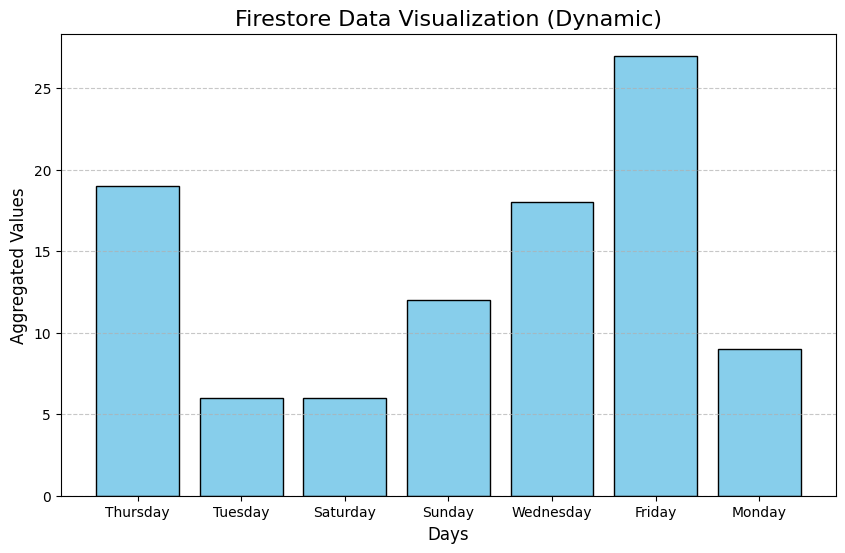

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Example data storage
data = {}

# Update the `data` dictionary in the `on_snapshot` function
def on_snapshot(doc_snapshot, changes, read_time):
    global data
    data = {doc.id: doc.to_dict() for doc in doc_snapshot}
    plot_data()

# Function to plot data
def plot_data():
    global data
    if not data:  # Ensure there's data to plot
        print("No data to visualize")
        return

    # Aggregate data dynamically
    aggregated_data = {}
    for doc_id, doc_data in data.items():
        for key, value in doc_data.items():
            if key not in aggregated_data:
                aggregated_data[key] = 0
            aggregated_data[key] += value if isinstance(value, (int, float)) else 0

    # Extract days and values dynamically
    days = list(aggregated_data.keys())
    values = list(aggregated_data.values())

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.bar(days, values, color="skyblue", edgecolor="black")
    plt.title("Firestore Data Visualization (Dynamic)", fontsize=16)
    plt.xlabel("Days", fontsize=12)
    plt.ylabel("Aggregated Values", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Add the listener
query_watch = collection_ref.on_snapshot(on_snapshot)


## Password distribution (2/12)

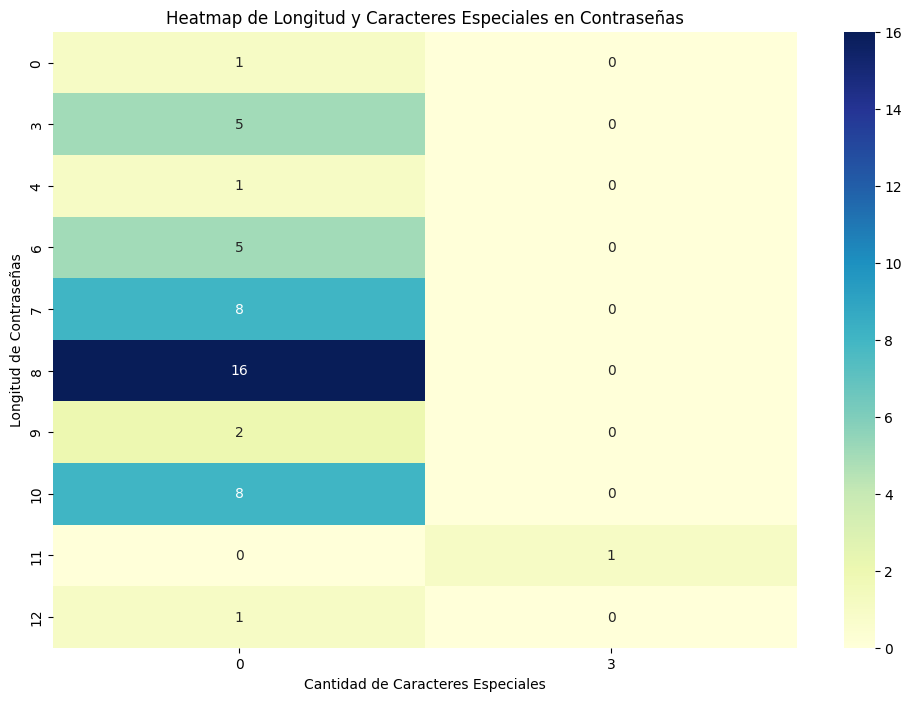

In [5]:
# Extraer datos de la colección `users`
users_ref = db.collection("users")
docs = users_ref.stream()

# Procesar datos
data = []
for doc in docs:
    user_data = doc.to_dict()
    password = user_data.get("password", "")  # Obtener la contraseña
    length = len(password)  # Longitud de la contraseña
    special_chars = len(re.findall(r'[!@#$%^&*(),.?":{}|<>]', password))  # Contar caracteres especiales
    data.append({"length": length, "special_chars": special_chars})

# Convertir a DataFrame
df = pd.DataFrame(data)

# Agrupar datos para el heatmap
heatmap_data = df.groupby(["length", "special_chars"]).size().unstack(fill_value=0)

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Heatmap de Longitud y Caracteres Especiales en Contraseñas")
plt.xlabel("Cantidad de Caracteres Especiales")
plt.ylabel("Longitud de Contraseñas")
plt.show()

## PArking lot vs EV (3/12)

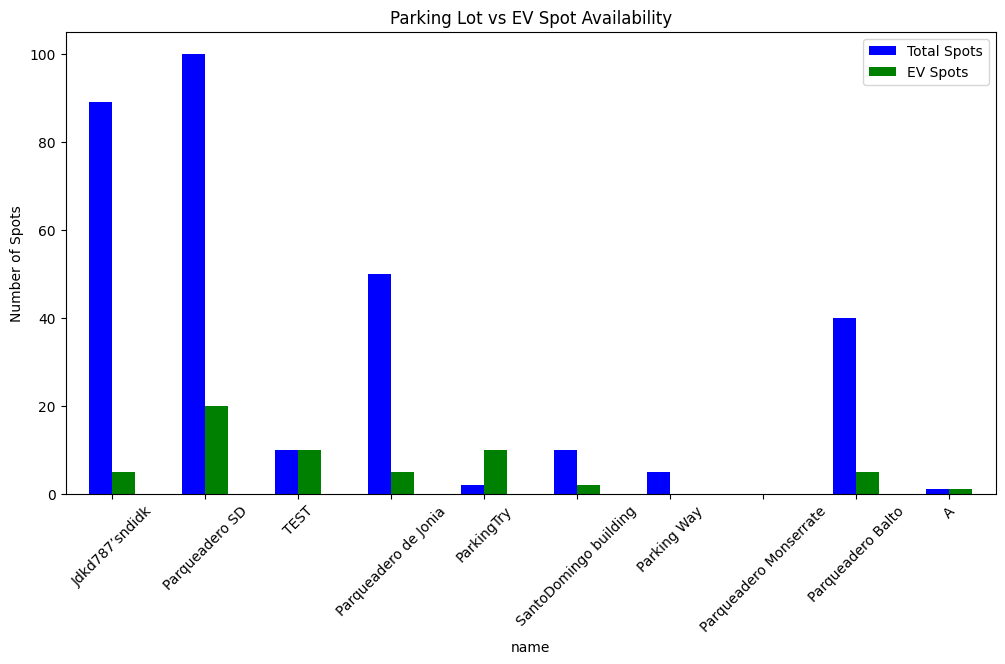

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract data from Firestore
parking_lots_ref = db.collection("parkingLots")
docs = parking_lots_ref.stream()

data = []
for doc in docs:
    parking_data = doc.to_dict()
    data.append({
        "name": parking_data.get("name", "Unknown"),
        "availableSpots": parking_data.get("availableSpots", 0),
        "available_ev_spots": parking_data.get("available_ev_spots", 0)
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Bar Chart
df.plot(x="name", kind="bar", stacked=False, figsize=(12, 6), color=["blue", "green"], 
        title="Parking Lot vs EV Spot Availability", ylabel="Number of Spots")
plt.legend(["Total Spots", "EV Spots"])
plt.xticks(rotation=45)
plt.show()


## Age distribution (4/12)

Invalid dateOfBirth format for document ID 3sTt3sFppClQvt42FPOt: ABC
Invalid dateOfBirth format for document ID Usp2TOZxnAFR4NHIzdQ1: ABC


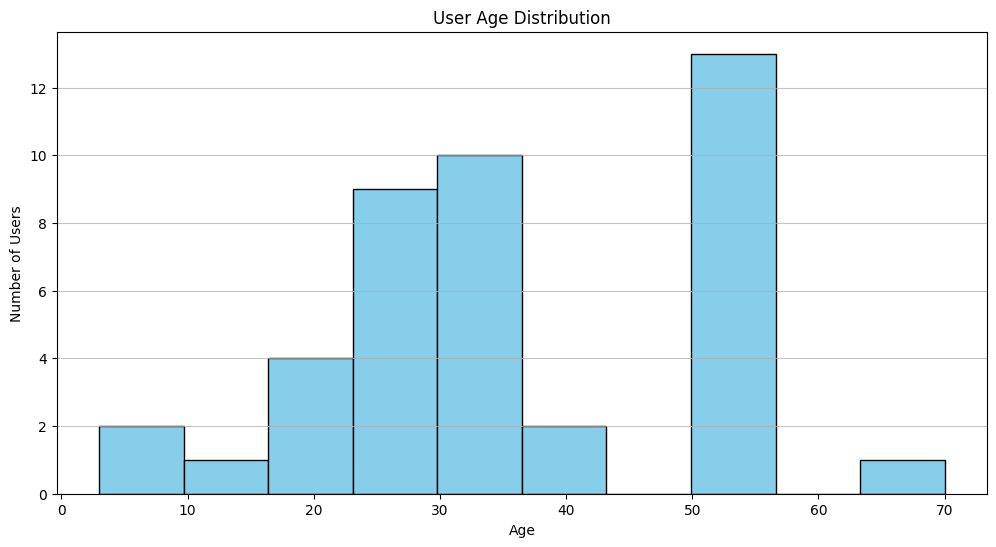

In [7]:
from datetime import datetime
import numpy as np

users_ref = db.collection("users")
docs = users_ref.stream()

current_year = datetime.now().year
ages = []

for doc in docs:
    user_data = doc.to_dict()
    dob = user_data.get("dateOfBirth", None)
    if dob:
        try:
            birth_year = int(dob.split("/")[-1])  # Extract year from "dd/mm/yyyy"
            # Validate that the extracted year is within a reasonable range
            if 1900 <= birth_year <= current_year:  
                age = current_year - birth_year
                ages.append(age)
        except ValueError:
            print(f"Invalid dateOfBirth format for document ID {doc.id}: {dob}")

# Histograma
if ages:
    plt.figure(figsize=(12, 6))
    plt.hist(ages, bins=10, color="skyblue", edgecolor="black")
    plt.title("User Age Distribution")
    plt.xlabel("Age")
    plt.ylabel("Number of Users")
    plt.grid(axis="y", alpha=0.75)
    plt.show()
else:
    print("No valid age data available for visualization.")


## Comparar Precios (5/12)

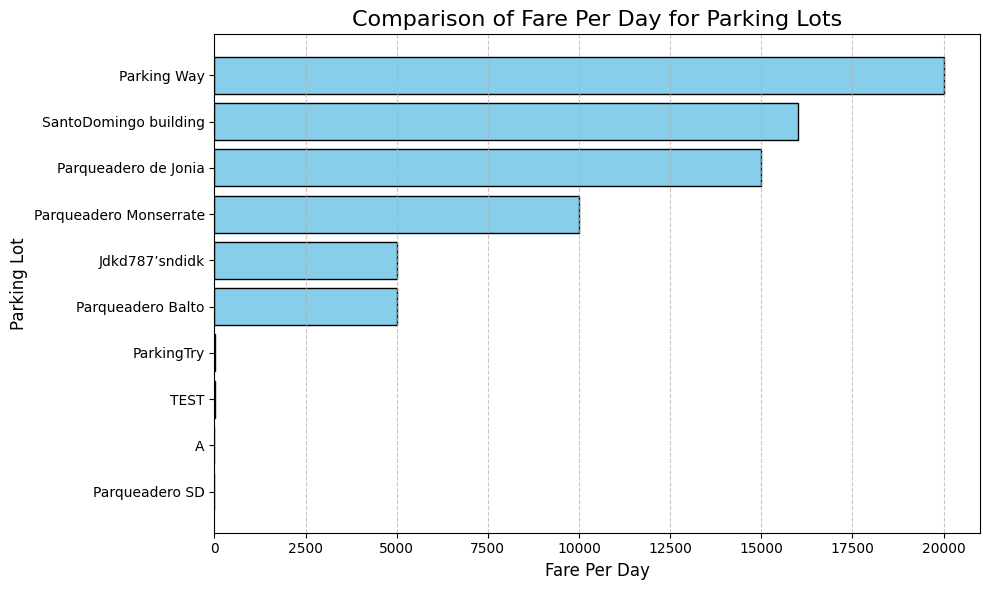

In [8]:
# Extract data from Firestore
parking_lots_ref = db.collection("parkingLots")
docs = parking_lots_ref.stream()

# Collect data
data = []
for doc in docs:
    parking_data = doc.to_dict()
    data.append({
        "name": parking_data.get("name", "Unknown"),
        "farePerDay": parking_data.get("farePerDay", 0)
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Sort data by farePerDay for better visualization
df = df.sort_values(by="farePerDay", ascending=True)

# Create a Horizontal Bar Chart
plt.figure(figsize=(10, 6))
plt.barh(df["name"], df["farePerDay"], color="skyblue", edgecolor="black")
plt.title("Comparison of Fare Per Day for Parking Lots", fontsize=16)
plt.xlabel("Fare Per Day", fontsize=12)
plt.ylabel("Parking Lot", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show chart
plt.tight_layout()
plt.show()

## Contador de EVs por parqueadero (6/12)

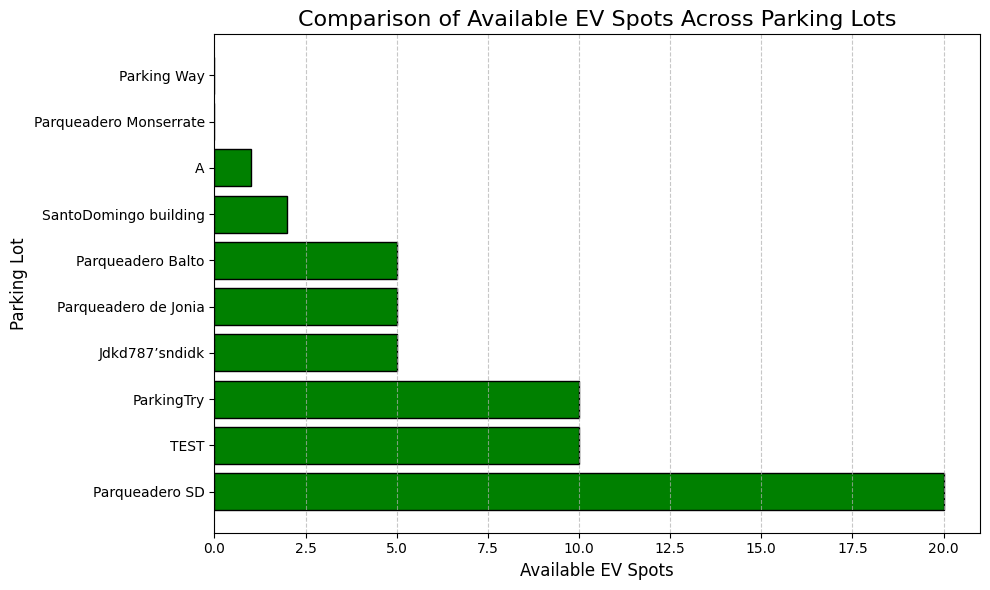

In [9]:
# Extract data from Firestore
parking_lots_ref = db.collection("parkingLots")
docs = parking_lots_ref.stream()

# Collect data
data = []
for doc in docs:
    parking_data = doc.to_dict()
    data.append({
        "name": parking_data.get("name", "Unknown"),
        "available_ev_spots": parking_data.get("available_ev_spots", 0)
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Sort by available EV spots
df = df.sort_values(by="available_ev_spots", ascending=False)

# Create a Horizontal Bar Chart
plt.figure(figsize=(10, 6))
plt.barh(df["name"], df["available_ev_spots"], color="green", edgecolor="black")
plt.title("Comparison of Available EV Spots Across Parking Lots", fontsize=16)
plt.xlabel("Available EV Spots", fontsize=12)
plt.ylabel("Parking Lot", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show chart
plt.tight_layout()
plt.show()

## Comparacion de ingresos por fecha (7/12)

C:\Users\carlo\AppData\Local\Temp\ipykernel_22416\921793818.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df_all.groupby(["day_of_week", "parking_lot"])["fare_amount"].sum().reset_index()


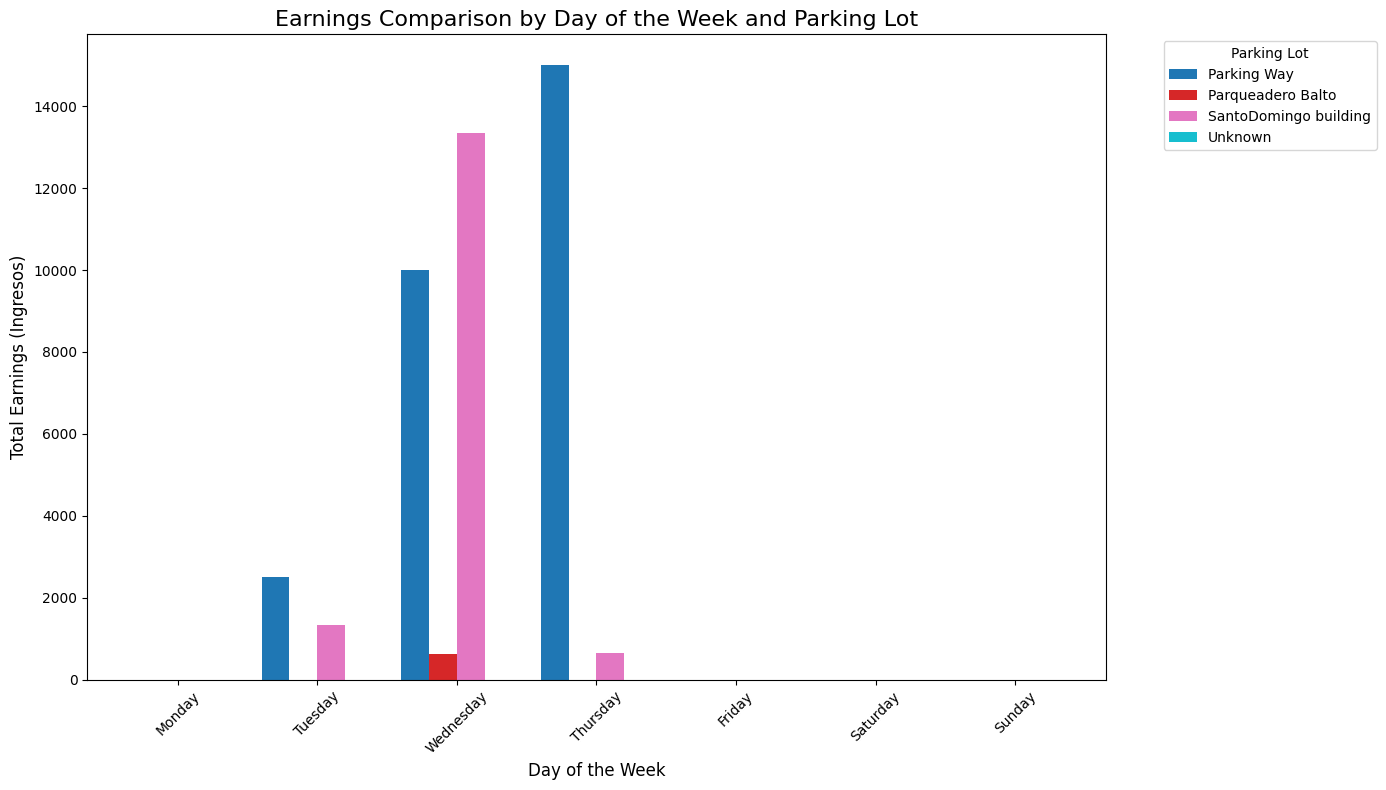

In [10]:
# Step 2: Fetch Data from Firestore
reservations_ref = db.collection("reservations")
docs = reservations_ref.stream()

# Collect data from Firestore
data = []
for doc in docs:
    reservation = doc.to_dict()
    start_time = reservation.get("startTime", None)
    parking_lot_name = reservation.get("parkingLotName", "Unknown")
    fare_amount = reservation.get("fareAmount", 0)
    
    if start_time and isinstance(start_time, datetime):  # Check if start_time is a valid datetime
        day_of_week = start_time.strftime("%A")  # Extract day of the week
        data.append({
            "day_of_week": day_of_week,
            "parking_lot": parking_lot_name,
            "fare_amount": fare_amount
        })

# Step 3: Convert Data to DataFrame
df_all = pd.DataFrame(data)

# Step 4: Ensure Days Are Ordered Correctly
df_all["day_of_week"] = pd.Categorical(
    df_all["day_of_week"],
    categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    ordered=True,
)

# Step 5: Aggregate Data for Plotting
grouped_data = df_all.groupby(["day_of_week", "parking_lot"])["fare_amount"].sum().reset_index()
pivot_data = grouped_data.pivot(index="day_of_week", columns="parking_lot", values="fare_amount").fillna(0)

# Step 6: Plot the Grouped Bar Chart
pivot_data.plot(kind="bar", figsize=(14, 8), width=0.8, colormap="tab10")
plt.title("Earnings Comparison by Day of the Week and Parking Lot", fontsize=16)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Total Earnings (Ingresos)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Parking Lot", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Parking Fare indicator by ubicacion (8/12)

In [11]:
import firebase_admin
from firebase_admin import credentials, firestore
import folium

# Step 2: Fetch Data from Firestore
parking_lots_ref = db.collection("parkingLots")
docs = parking_lots_ref.stream()

# Collect parking lot data
parking_data = []
for doc in docs:
    parking_lot = doc.to_dict()
    if "latitude" in parking_lot and "longitude" in parking_lot:
        parking_data.append({
            "name": parking_lot.get("name", "Unknown"),
            "latitude": parking_lot["latitude"],
            "longitude": parking_lot["longitude"],
            "farePerDay": parking_lot.get("farePerDay", 0),
            "availableSpots": parking_lot.get("availableSpots", "N/A"),
            "available_ev_spots": parking_lot.get("available_ev_spots", "N/A")
        })

# Step 3: Create the Map
# Default map center is Bogotá, Colombia
bogota_lat, bogota_lng = 4.711, -74.0721
parking_map = folium.Map(location=[bogota_lat, bogota_lng], zoom_start=13)

# Step 4: Add Markers to the Map
for lot in parking_data:
    popup_content = f"""
    <b>{lot['name']}</b><br>
    <b>Daily Fare:</b> ${lot['farePerDay']}<br>
    <b>Available Spots:</b> {lot['availableSpots']}<br>
    <b>EV Spots:</b> {lot['available_ev_spots']}
    """
    folium.CircleMarker(
        location=[lot["latitude"], lot["longitude"]],
        radius=lot["farePerDay"] / 1000,  # Scale radius by farePerDay
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.6,
        popup=folium.Popup(popup_content, max_width=250)
    ).add_to(parking_map)

# Step 5: Save and Display the Map
parking_map.save("parking_lot_performance_map.html")
parking_map


## Conectivity (9/12)

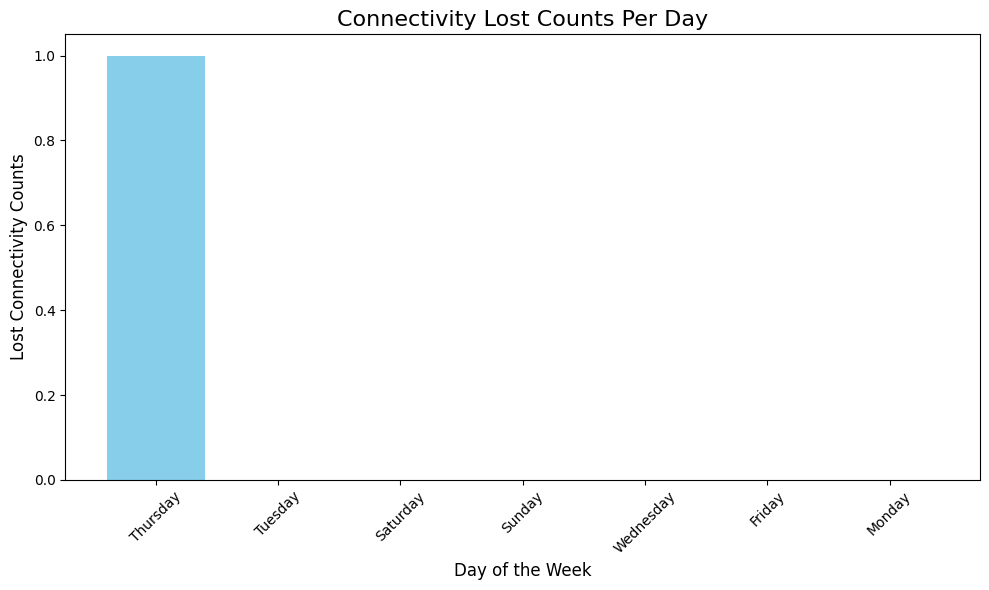

In [12]:
# Fetch ConnectivityAnalytics data
connectivity_ref = db.collection("data").document("ConnectivityAnalytics")
connectivity_data = connectivity_ref.get().to_dict()

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(connectivity_data.keys(), connectivity_data.values(), color='skyblue')
plt.title("Connectivity Lost Counts Per Day", fontsize=16)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Lost Connectivity Counts", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Navigation (10/12)

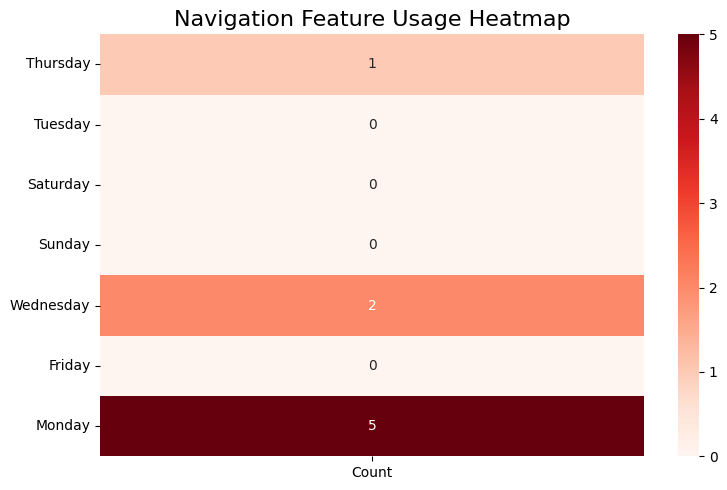

In [13]:
import seaborn as sns
import pandas as pd

# Fetch NavigationAnalytics data
navigation_ref = db.collection("data").document("NavigationAnalytics")
navigation_data = navigation_ref.get().to_dict()

# Prepare data
days = list(navigation_data.keys())
counts = list(navigation_data.values())

# Convert data to DataFrame for heatmap
navigation_df = pd.DataFrame({'Day': days, 'Count': counts}).set_index('Day')

# Visualization: Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(navigation_df, annot=True, fmt="d", cmap="Reds", cbar=True)
plt.title("Navigation Feature Usage Heatmap", fontsize=16)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()


## Detail Analytics (11/12)

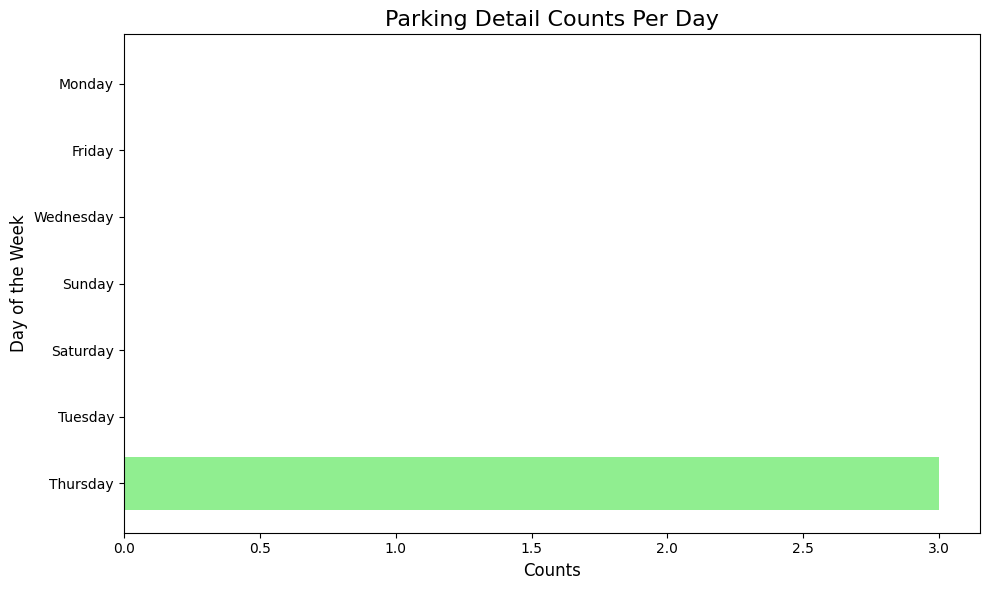

In [14]:
# Fetch DetailAnalytics data
detail_ref = db.collection("data").document("DetailAnalytics")
detail_data = detail_ref.get().to_dict()

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(list(detail_data.keys()), list(detail_data.values()), color='lightgreen')
plt.title("Parking Detail Counts Per Day", fontsize=16)
plt.xlabel("Counts", fontsize=12)
plt.ylabel("Day of the Week", fontsize=12)
plt.tight_layout()
plt.show()


## Sign-In Analytics (12/12)

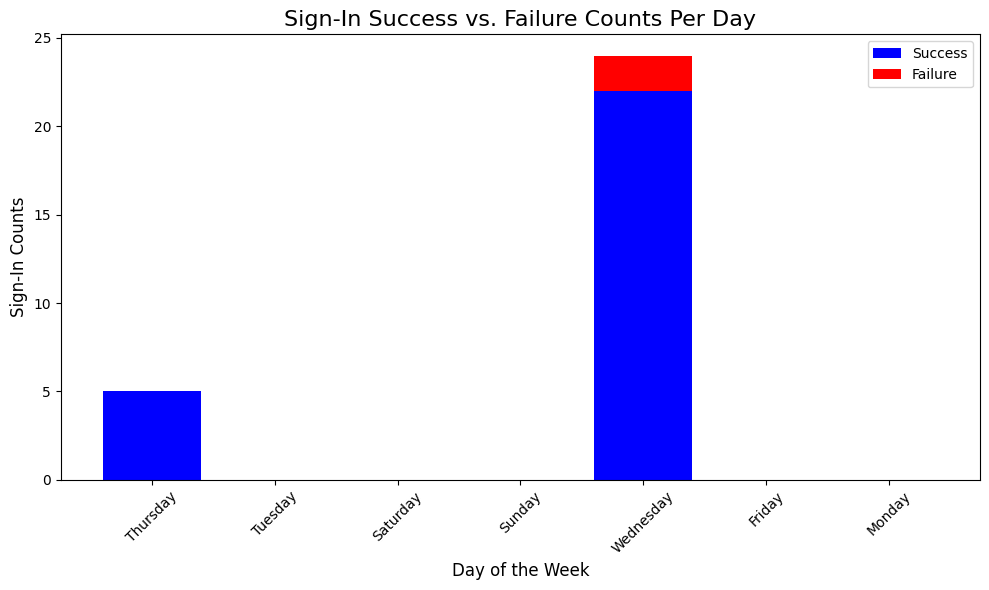

In [15]:
import numpy as np

# Fetch SignInAnalytics data
signin_ref = db.collection("data").document("SignInAnalytics")
signin_data = signin_ref.get().to_dict()

# Prepare data
days = list(signin_data.keys())
success = [signin_data[day][0] for day in days]  # Successful sign-ins
failure = [signin_data[day][1] for day in days]  # Failed sign-ins

# Visualization
x = np.arange(len(days))
plt.figure(figsize=(10, 6))
plt.bar(x, success, label='Success', color='blue')
plt.bar(x, failure, label='Failure', bottom=success, color='red')
plt.title("Sign-In Success vs. Failure Counts Per Day", fontsize=16)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Sign-In Counts", fontsize=12)
plt.xticks(x, days, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Sign-Up Analytics (13/12)

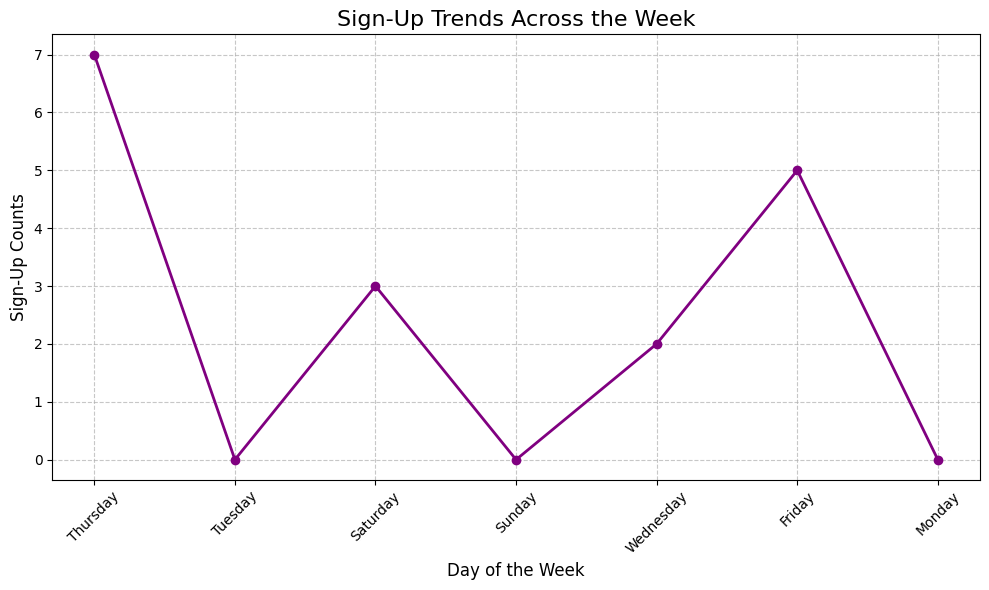

In [16]:
# Fetch SignUpAnalytics data
signup_ref = db.collection("data").document("SignUpAnalytics")
signup_data = signup_ref.get().to_dict()

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(list(signup_data.keys()), list(signup_data.values()), marker='o', color='purple', linestyle='-', linewidth=2)
plt.title("Sign-Up Trends Across the Week", fontsize=16)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Sign-Up Counts", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
